## Xenium niche analysis (annotation refinement and niche plotting)

In [1]:
import sys 
import os
from datetime import datetime
today = datetime.now().strftime("%Y-%m-%d")
import anndata as ad
import hdf5plugin
import squidpy as sq
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

/nfs/team205/vk8/mambaforge/envs/squidpy-env3/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/nfs/team205/vk8/mambaforge/envs/squidpy-env3/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/nfs/team205/vk8/mambaforge/envs/squidpy-env3/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/nfs/team205/vk8/mambaforge/envs/squidpy-env3/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/nfs/team205/vk8/mambaforge/envs/squidpy-env3/lib/python3.12/s

import scvi
import cellcharter as cc
from lightning.pytorch import seed_everything

seed_everything(12345)
scvi.settings.seed = 12345

In [2]:
# Add repo path to sys path (allows to access scripts and metadata from repo)
repo_path = '/nfs/team205/vk8/projects/thymus_ageing_atlas/Spatial_analyses/'
sys.path.insert(1, repo_path) 
sys.path.insert(2, '/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts')

%reload_ext autoreload

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

In [4]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
sc.settings.set_figure_params(dpi = 80, color_map = 'RdPu', vector_friendly = True, format = 'pdf',  dpi_save=300)
from matplotlib import font_manager
font_manager.fontManager.addfont("/nfs/team205/ny1/ThymusSpatialAtlas/software/Arial.ttf")
#plt.style.use(f'/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/thyAgeing.mplstyle')

In [5]:
plt.style.use(f'/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/thyAgeing.mplstyle')

In [6]:
# Define plot and path dirs
plot_path = os.path.join(repo_path, 'plots')
data_path = os.path.join(repo_path, 'data')
model_path = os.path.join(repo_path, 'models')
results_path = os.path.join(repo_path, 'results')
general_data_path = '/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/data'

In [7]:
import seaborn as sns
thyAgeing_colors = pd.read_csv("/nfs/team205/lm25/thymus_projects/thymus_ageing_atlas/General_analysis/scripts/plotting/thyAgeing_colors.csv").set_index('color_name')['hex'].to_dict()
niche_enrich_palette = sns.blend_palette([thyAgeing_colors['blue'], thyAgeing_colors['purple'], thyAgeing_colors['magenta'], thyAgeing_colors['orange'], thyAgeing_colors['yellow']], as_cmap=True,)

In [8]:
thyAgeing_colors

{'blue': '#648FFF',
 'purple': '#785EF0',
 'magenta': '#DC267F',
 'orange': '#FE6100',
 'yellow': '#FFB000',
 'teal': '#18868F',
 'mint': '#738B79',
 'pink': '#C169E8',
 'grass': '#82CD29',
 'forest': '#124420'}

## Load Xenium object and combine with the transferred annotations

In [9]:
xenium_adata = ad.read_h5ad(f'{data_path}/xenium/adata_xenium_2025-01-14.zarr')

In [10]:
sc.pp.filter_cells(xenium_adata, min_counts = 100)
knn_pred_df = pd.read_csv(f'{data_path}/xenium/ThyAge_xenium_scarches_annos_2025-04-09.csv', index_col = 0)
knn_cols = knn_pred_df.columns.tolist()
xenium_adata.obs[knn_cols] = knn_pred_df.reindex(xenium_adata.obs_names)

## Load single-cell embedding

In [13]:
import pickle 
with open (f'{data_path}/xenium/ThyAge_scell2xenium_integ_2025-04-09_embed.pickle', 'rb') as file:
    scell2xen_embed = pickle.load(file)

In [14]:
xenium_adata.obsm['X_scVI'] = scell2xen_embed['X_scVI'].copy()
xenium_adata.obsm['X_umap'] = scell2xen_embed['X_umap'].copy()
xenium_adata.obsp = scell2xen_embed['obsp'].copy()

## Load Cellcharter niches

In [ ]:
clusters = ['cluster_cellcharter', 'cluster_cellcharter6', 'cluster_cellcharter10']
xenium_adata.obs[clusters] = pd.read_csv(f'{data_path}/xenium/ThyAge_xenium_adata_paed+adult_CellCharter_clusters.csv', index_col = 0).reindex(xenium_adata.obs_names)

## Rename and format niches

In [12]:
xenium_adata.obs['cluster_cellcharter6'] = xenium_adata.obs['cluster_cellcharter6'].astype("category")
cluster6anno  = {0: 'Cortex', 1: 'InflammatoryPVS', 2: 'Medulla', 3: 'Capsule/PVS', 4: 'Adipose', 5:'mcTEC-rich'}
cluster6order = ['Capsule/PVS', 'Cortex', 'Medulla', 'mcTEC-rich', 'InflammatoryPVS', 'Adipose']

xenium_adata.obs['niche_cellcharter6'] = xenium_adata.obs['cluster_cellcharter6'].map(cluster6anno)
xenium_adata.obs['niche_cellcharter6'] = xenium_adata.obs['niche_cellcharter6'].cat.reorder_categories(cluster6order).copy()

In [ ]:
xenium_adata.obs['cluster_cellcharter'] = xenium_adata.obs['cluster_cellcharter'].astype("category")
cluster_anno  = {0: 'Cortex', 1: 'Medulla', 2: 'PVS'}
cluster3order = ['Cortex', 'Medulla', 'PVS']

xenium_adata.obs['niche_cellcharter3'] = xenium_adata.obs['cluster_cellcharter'].map(cluster_anno)
xenium_adata.obs['niche_cellcharter3'] = xenium_adata.obs['niche_cellcharter3'].cat.reorder_categories(cluster3order).copy()

In [14]:
xenium_adata.obs['niche_cellcharter3_v2'] = xenium_adata.obs['niche_cellcharter6'].apply(lambda x: 'Cortex' if x in ['Capsule/PVS', 'Cortex'] else
                                                                                         'Medulla' if x in ['Medulla', 'mcTEC-rich'] else
                                                                                         'PVS' if x in ['InflammatoryPVS', 'Adipose'] else x)

In [15]:
xenium_adata.obs['niche_cellcharter3_v2'] = xenium_adata.obs['niche_cellcharter3_v2'].astype('category')
xenium_adata.obs['niche_cellcharter3_v2'] = xenium_adata.obs['niche_cellcharter3_v2'].cat.reorder_categories(cluster3order)

## Pre-filter to high confidence label transfer annotations and incorporate manually refined annotations

In [26]:
xenium_adata.obs['70prob'] = xenium_adata.obs['knn_uncert-taa_l1']<0.3
xenium_adata.obs['50prob'] = xenium_adata.obs['knn_uncert-taa_l1']<0.5

In [27]:
np.sum(xenium_adata.obs['70prob'])

1754633

In [28]:
np.sum(xenium_adata.obs['50prob'])

1882383

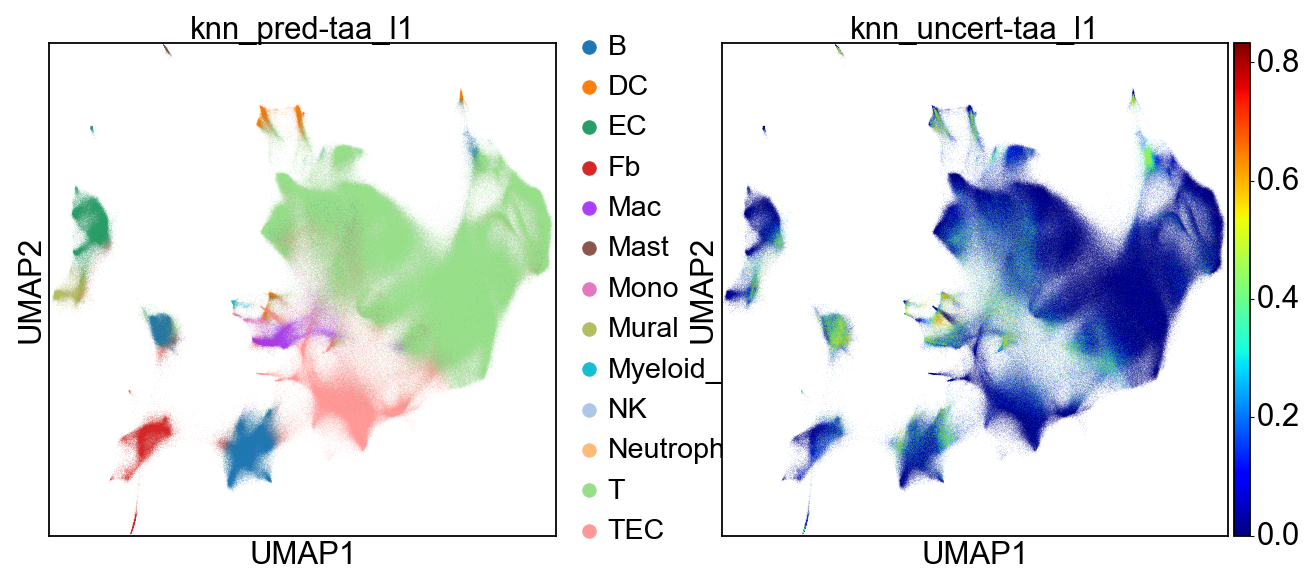

In [23]:
sc.pl.umap(xenium_adata, color = ['knn_pred-taa_l1', 'knn_uncert-taa_l1'], cmap = 'jet')

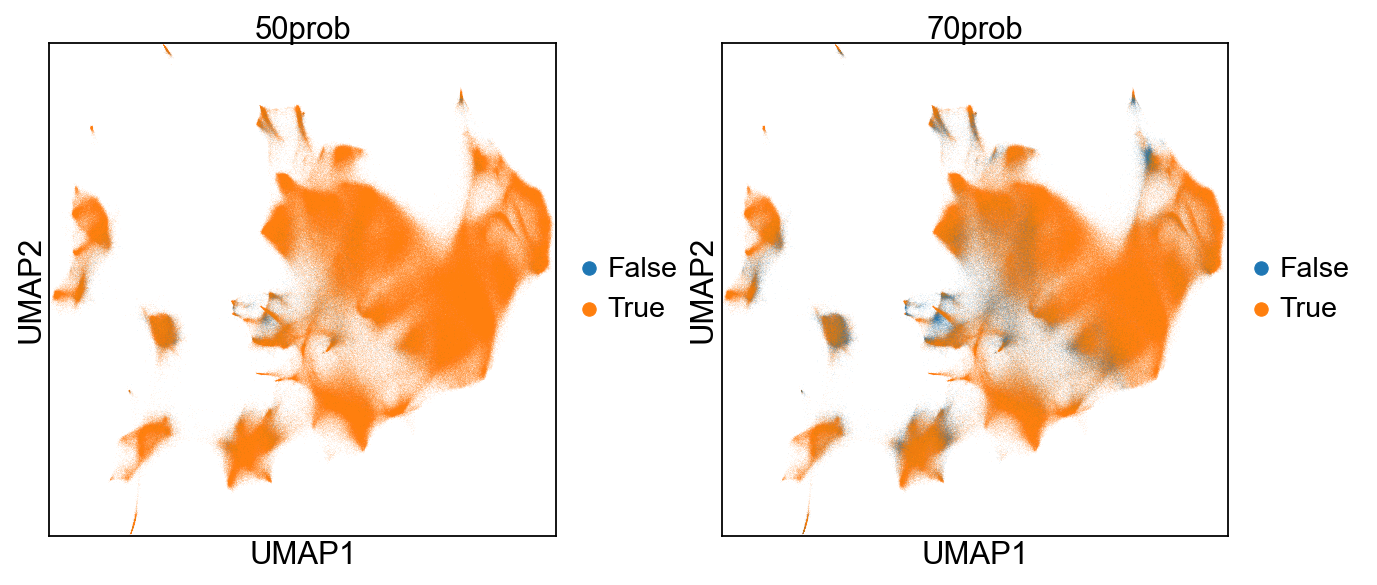

In [29]:
sc.pl.umap(xenium_adata, color = ['50prob', '70prob'], cmap = 'jet')

In [30]:
TEC_anno = pd.read_csv(f'{data_path}/xenium/ThyAge_xenium_scarches_2025-04-09_TEC_manual_anno.csv', index_col = 0)
B_anno = pd.read_csv('/nfs/team205/vk8/projects/thymus_ageing_atlas/B_compartment/data/objects/xenium/thyAgeing_bSplitXenium_scvi_v2_2025-03-26_v2.csv', index_col = 0)
xenium_adata.obs['manual_anno'] = xenium_adata.obs['knn_pred-taa_l3'].copy()
xenium_adata.obs['manual_anno'] = xenium_adata.obs['manual_anno'].astype(str)

In [31]:
scell2xen_fbs = ad.read_h5ad(f'{data_path}/xenium/scell2xenium/adata_scell2xenium_FbAdipo_filt_2025-07-28.zarr')

In [32]:
xenium_adata.obs.loc[TEC_anno.index, 'manual_anno'] = TEC_anno['TEC_anno'].copy()
xenium_b_cells = np.intersect1d(xenium_adata.obs_names,B_anno.index)
len(xenium_b_cells)
xenium_adata.obs.loc[xenium_b_cells, 'manual_anno'] = B_anno.loc[xenium_b_cells, 'taa_l5'].copy()

xenium_fbs = np.intersect1d(xenium_adata.obs_names,scell2xen_fbs.obs_names)
xenium_adata.obs.loc[xenium_fbs, 'manual_anno'] = scell2xen_fbs.obs.loc[xenium_fbs, 'Fb_int_anno'].copy()

172286

In [39]:
xenium_adata.obs[knn_cols+['manual_anno', '70prob', '50prob', 'niche_cellcharter3', 'niche_cellcharter3_v2','niche_cellcharter6']].to_csv(f'{data_path}/xenium/annos_v3/ThyAge_xenium_adata_paed+adult_CellCharter_knn_manual_annos_full_{today}.csv',
                                                                                                                                          index=True)

In [52]:
cols = ['70prob', '50prob']
sample_prob_means = xenium_adata.obs.groupby('SampleID', observed=True)[cols].mean()
sample_prob_means

sample_cnts = xenium_adata.obs.groupby('SampleID', observed=True)[cols].count()
sample_cnts
# optional: save
# sample_prob_means.to_csv(f'{results_path}/sample_prob_means_{today}.csv')

,70prob,50prob
SampleID,,
A45-THY-0-FFPE-1,0.876849,0.958315
A67-THY-0-FFPE-1,0.886246,0.977578
A70-THY-0-FFPE-2,0.902914,0.980396
A72-THY-0-FFPE-1,0.908019,0.982622
Z16-THY-0-FF-1,0.960828,0.995335
Z17-THY-0-FF-1,0.937253,0.989465


,70prob,50prob
SampleID,,
A45-THY-0-FFPE-1,8924,8924
A67-THY-0-FFPE-1,161445,161445
A70-THY-0-FFPE-2,134613,134613
A72-THY-0-FFPE-1,958935,958935
Z16-THY-0-FF-1,197413,197413
Z17-THY-0-FF-1,450010,450010


In [62]:
xenium_adata_filt = xenium_adata[((xenium_adata.obs['70prob']==True) & (xenium_adata.obs['SampleID'] != 'A45-THY-0-FFPE-1')) & (~xenium_adata.obs['manual_anno'].isnull()),:].copy()

### Reorder annotations according to the levels

In [54]:
# Import custom scripts
from utils import get_latest_version,update_obs,freq_by_donor
from anno_levels import get_ct_levels, get_ct_palette, age_group_levels, age_group_palette

In [55]:
ctype_lev3 = get_ct_levels(level = 'taa_l3')

Latest file: thyAgeing_full_curatedAnno_v11_2025-08-29_levels.xlsx


In [66]:
np.setdiff1d(ctype_lev3, xenium_adata_filt.obs['manual_anno'].unique().tolist())

array(['B_med'], dtype='<U18')

In [67]:
np.setdiff1d(xenium_adata_filt.obs['manual_anno'].unique().tolist(), ctype_lev3)

array(['B_plasma_IgE', 'B_plasmablast', 'Fb-interlo_PI16',
       'Fb-perilo_COLEC11', 'TEC-cilliated', 'TEC-iono', 'TEC-myo',
       'TEC-neuro', 'mTECI-trans'], dtype='<U18')

In [69]:
xenium_adata_filt.obs['taa_l3'] = xenium_adata_filt.obs['manual_anno'].apply(lambda x: 'B_plasma' if x in ['B_plasma_IgE', 'B_plasmablast'] else
                                                                   'Fb-interlo' if x == 'Fb-interlo_PI16' else
                                                                   'Fb-perilo' if x == 'Fb-perilo_COLEC11' else
                                                                   'TEC-mim' if x in ['TEC-cilliated', 'TEC-iono', 
                                                                                      'TEC-myo','TEC-neuro'] else
                                                                    'T_CD4_recirc' if x == 'T_CD4_naive_recirc' else
                                                                   'mTECI' if x == 'mTECI-trans' else
                                                                   x)

In [70]:
ctype_anno = pd.read_excel(f'{general_data_path}/curated/thyAgeing_full_curatedAnno_v11_2025-08-29_levels.xlsx')

In [71]:
ctype_lev3 = ['T_DN(early)',
 'T_DN',
 'T_DP',
 'T_αβT(entry)',
 'T_CD8',
 'T_CD4',
 'T_Treg',
 'T_CD8_recirc',
 'T_CD4_recirc',
 'T_Treg_recirc',
 'T_CD8αα',
 'T_MAIT',
 'ILC',
 'T_γδT',
 'NK',
 'cTEC',
 'mcTEC',
 'mTECI',
 'mTECII',
 'mTECIII',
 'TEC-mim',
 'TEC-EMT',
 'Fb-interlo',
 'Fb-perilo',
 'Fb-med',
 'Fb-interm',
 'Fb-adipo',
 'Adipocyte',
 'EC-art',
 'EC-cap',
 'EC-cap_lipid',
 'EC-ven',
 'EC-peri',
 'EC-lymphatic',
 'SMC',
 'Pericyte',
 'B_dev',
 'B_naive',
 'B_mem',
 'B_GC-like',
 'B_plasma',
 'Myeloid_dev',
 'Neutrophil',
 'Mono',
 'Mac',
 'DC1',
 'DC2',
 'aDC',
 'DC',
 'pDC',
 'Mast']

ctype_lev3 = ['T_DN(early)',
 'T_DN',
 'T_DP',
 'T_αβT(entry)',
 'T_CD8',
 'T_CD4',
 'T_Treg',
 'T_CD8_recirc',
 'T_CD4_recirc',
 'T_CD4_naive_recirc',
 'T_Treg_recirc',
 'T_CD8αα',
 'T_MAIT',
 'ILC',
 'T_γδT',
 'NK',
 'cTEC',
 'mcTEC',
 'mTECI',
'mTECI-trans',
 'mTECII',
 'mTECIII',
 'TEC-mim',
'TEC-neuro', 
'TEC-cilliated', 
'TEC-iono', 'TEC-myo',
 'TEC-EMT',
'Fb-interlo_PI16',
 'Fb-interlo',
 'Fb-interm',
 'Fb-adipo',
'Adipocyte',
 'Fb-perilo',
'Fb-perilo_COLEC11',
 'Fb-med',
 'EC-art',
 'EC-cap',
 'EC-cap_lipid',
 'EC-ven',
 'EC-peri',
 'EC-lymphatic',
 'SMC',
 'Pericyte',
 'B_dev',
 'B_naive',
 'B_mem',
 'B_GC-like',
 'B_plasma',
'B_plasma_IgE', 
'B_plasmablast',
 'Myeloid_dev',
 'Neutrophil',
 'Mono',
 'Mac',
 'DC1',
 'DC2',
 'aDC',
 'DC',
 'pDC',
 'Mast']

In [73]:
xenium_adata_filt.obs['taa_l3'] = xenium_adata_filt.obs['taa_l3'].astype('string')
ctype_anno2 = ctype_anno[['taa_l3', 'taa_l2_v2']].drop_duplicates().copy()
obs_upd = xenium_adata_filt.obs.merge(ctype_anno2, how = 'left', on = 'taa_l3').set_index(xenium_adata_filt.obs_names)
xenium_adata_filt.obs = obs_upd.copy()
sum(xenium_adata_filt.obs['taa_l3'].isnull())

0

In [74]:
xenium_adata_filt.obs['taa_l3'] = xenium_adata_filt.obs['taa_l3'].astype('category')
xenium_adata_filt.obs['taa_l3'] = xenium_adata_filt.obs['taa_l3'].cat.reorder_categories(ctype_lev3).copy()

In [76]:
xenium_adata_filt = xenium_adata_filt[xenium_adata_filt.obs['taa_l3']!='DC'].copy()

In [85]:
ctype_lev2 = ctype_anno2['taa_l2_v2'].unique().tolist()
ctype_lev2.remove('DC')

In [87]:
np.setdiff1d(ctype_lev2, xenium_adata_filt.obs['taa_l2_v2'].unique().tolist())

array([], dtype='<U12')

In [88]:
xenium_adata_filt.obs['taa_l2_v2'] = xenium_adata_filt.obs['taa_l2_v2'].astype('category')
xenium_adata_filt.obs['taa_l2_v2'] = xenium_adata_filt.obs['taa_l2_v2'].cat.reorder_categories(ctype_lev2).copy()

In [114]:
xenium_adata_filt.obs[['knn_pred-taa_l5',
       'knn_pred-taa_l4', 'knn_pred-taa_l3', 'knn_pred-taa_l2',
       'knn_pred-taa_l1', 'knn_pred-taa_l0', 'knn_uncert-taa_l5',
       'knn_uncert-taa_l4', 'knn_uncert-taa_l3', 'knn_uncert-taa_l2',
       'knn_uncert-taa_l1', 'knn_uncert-taa_l0', 'cluster_cellcharter',
       'cluster_cellcharter6', 'cluster_cellcharter10', 'niche_cellcharter6',
       'niche_cellcharter3', 'niche_cellcharter3_v2',
       'manual_anno', 'taa_l3', 'taa_l2_v2']].to_csv(f'{data_path}/xenium/annos_v3/ThyAge_xenium_adata_paed+adult_CellCharter_knn_manual_annos_filt_{today}.csv',
                                                     index = True)

In [29]:
from utils_vk8 import regen_embed

In [ ]:
%%time
regen_embed(xenium_adata_filt, anno2show = 'taa_l3')

In [33]:
sc.settings.set_figure_params(dpi = 80, color_map = 'RdPu', vector_friendly = True, format = 'pdf',  dpi_save=300)

## Plot UMAP

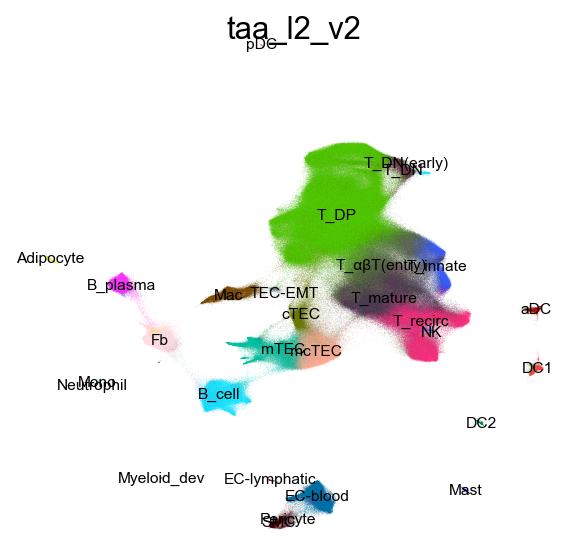

In [35]:
sc.pl.umap(xenium_adata_filt, color = 'taa_l2_v2', legend_loc = 'on data', frameon = False, legend_fontsize = 7, return_fig = True).savefig(f'{plot_path}/Xenium_UMAP2ctype_l2_v2.pdf', dpi = 150)

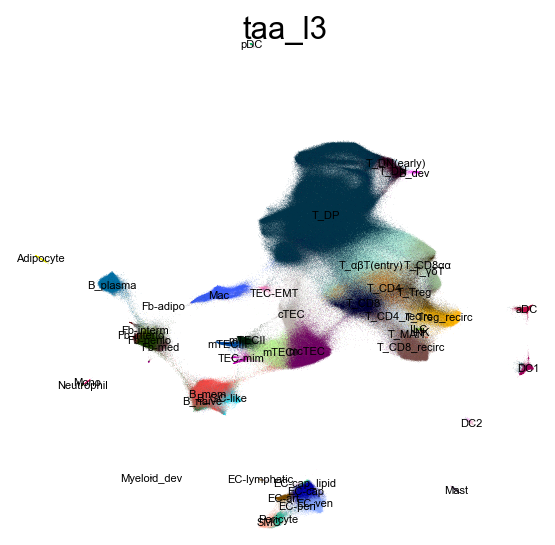

In [49]:
sc.pl.umap(xenium_adata_filt, color = 'taa_l3', legend_loc = 'on data', frameon = False, legend_fontsize = 5, return_fig = True).savefig(f'{plot_path}/Xenium_UMAP2ctype_l3_v2.pdf', dpi = 200)

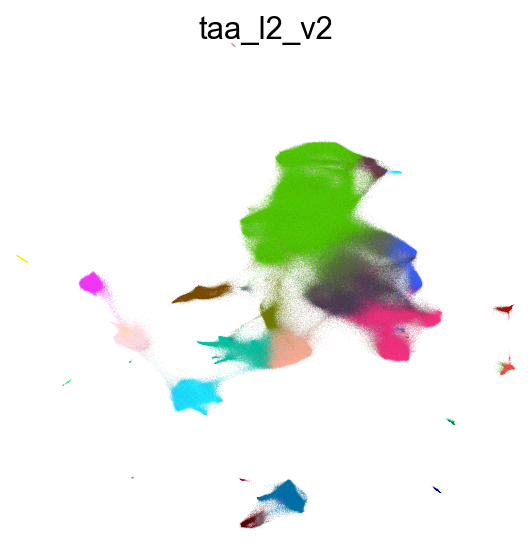

In [48]:
sc.pl.umap(xenium_adata_filt, color = 'taa_l2_v2', frameon = False, legend_loc = None, return_fig = True).savefig(f'{plot_path}/Xenium_UMAP2ctype_l2_v2.png', dpi = 300)

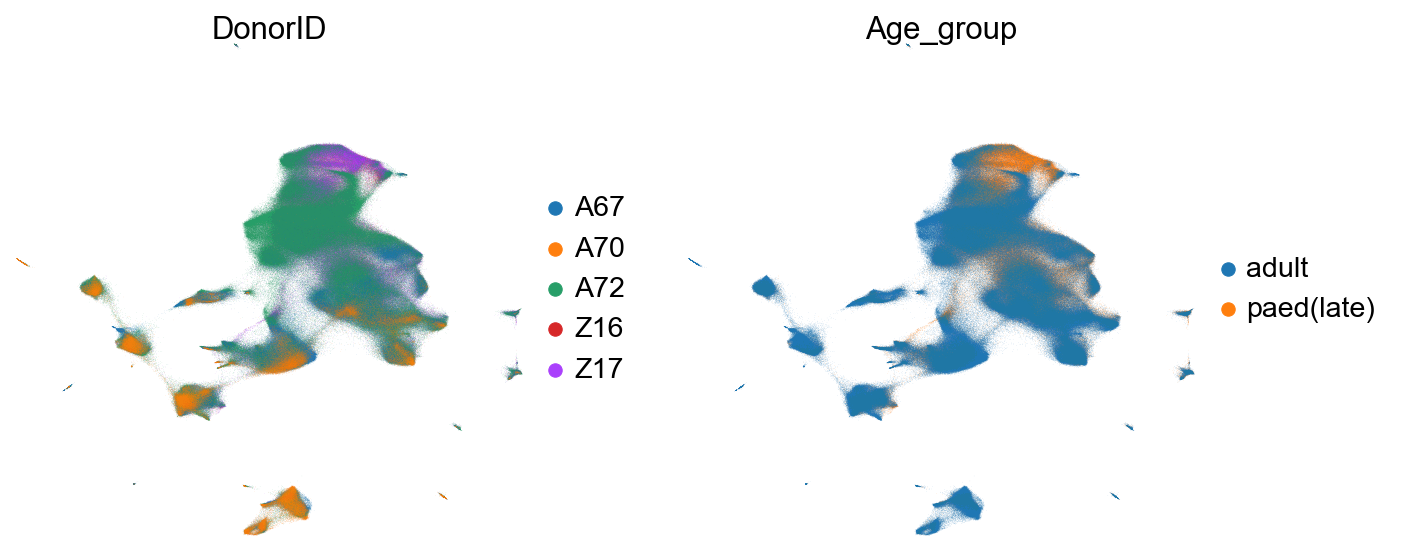

In [37]:
sc.pl.umap(xenium_adata_filt, color = ['DonorID', 'Age_group'], frameon = False,return_fig = True).savefig(f'{plot_path}/Xenium_UMAP2donor_agegroup_v2_v2.pdf', dpi = 150)

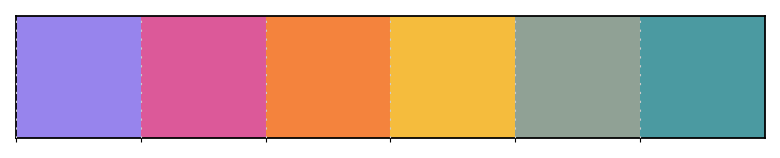

In [38]:
from matplotlib.colors import to_rgb, to_hex, ListedColormap
import colorsys
import seaborn as sns

niche_palette = [thyAgeing_colors['purple'], thyAgeing_colors['magenta'],
                 thyAgeing_colors['orange'], thyAgeing_colors['yellow'],
                 thyAgeing_colors['mint'],thyAgeing_colors['teal']]

def tint_palette(palette, tint_factor=0.5):
    """Tint colors in a palette towards white by tint_factor (0=original, 1=white)."""
    tinted = []
    for c in palette:
        r, g, b = to_rgb(c)
        r = r + (1 - r) * tint_factor
        g = g + (1 - g) * tint_factor
        b = b + (1 - b) * tint_factor
        tinted.append(to_hex((r, g, b)))
    return tinted

def desaturate_palette(palette, saturation_scale=0.7):
    """
    Reduce saturation of hex colors in a palette.
    saturation_scale < 1 decreases saturation, > 1 increases
    """
    new_palette = []
    for c in palette:
        r, g, b = to_rgb(c)                   # convert to 0–1 rgb
        h, l, s = colorsys.rgb_to_hls(r, g, b) # convert to hls
        s = max(0, min(1, s * saturation_scale)) # scale saturation safely
        r2, g2, b2 = colorsys.hls_to_rgb(h, l, s)
        new_palette.append(to_hex((r2, g2, b2)))
    return new_palette

tinted_niche_palette = tint_palette(desaturate_palette(niche_palette, saturation_scale = 0.9), tint_factor=0.2)

sns.palplot(tinted_niche_palette)


In [41]:
cluster6order = ['Capsule/PVS', 'Cortex', 'Medulla', 'mcTEC-rich', 'InflammatoryPVS', 'Adipose']
xenium_adata_filt.obs['niche_cellcharter6'] = xenium_adata_filt.obs['niche_cellcharter6'].astype('category')
xenium_adata_filt.obs['niche_cellcharter6'] = xenium_adata_filt.obs['niche_cellcharter6'].cat.reorder_categories(cluster6order).copy()
cluster3order = ['Cortex', 'Medulla', 'PVS']
xenium_adata_filt.obs['niche_cellcharter3_v2'] = xenium_adata_filt.obs['niche_cellcharter3_v2'].astype('category')
xenium_adata_filt.obs['niche_cellcharter3_v2'] = xenium_adata_filt.obs['niche_cellcharter3_v2'].cat.reorder_categories(cluster3order)

In [46]:
xenium_adata_filt.uns['niche_cellcharter3_v2_colors'] = ['#6e9e9b', '#f4a03d','#ba6ec3',]
xenium_adata_filt.uns['niche_cellcharter6_colors'] = tinted_niche_palette[::-1]

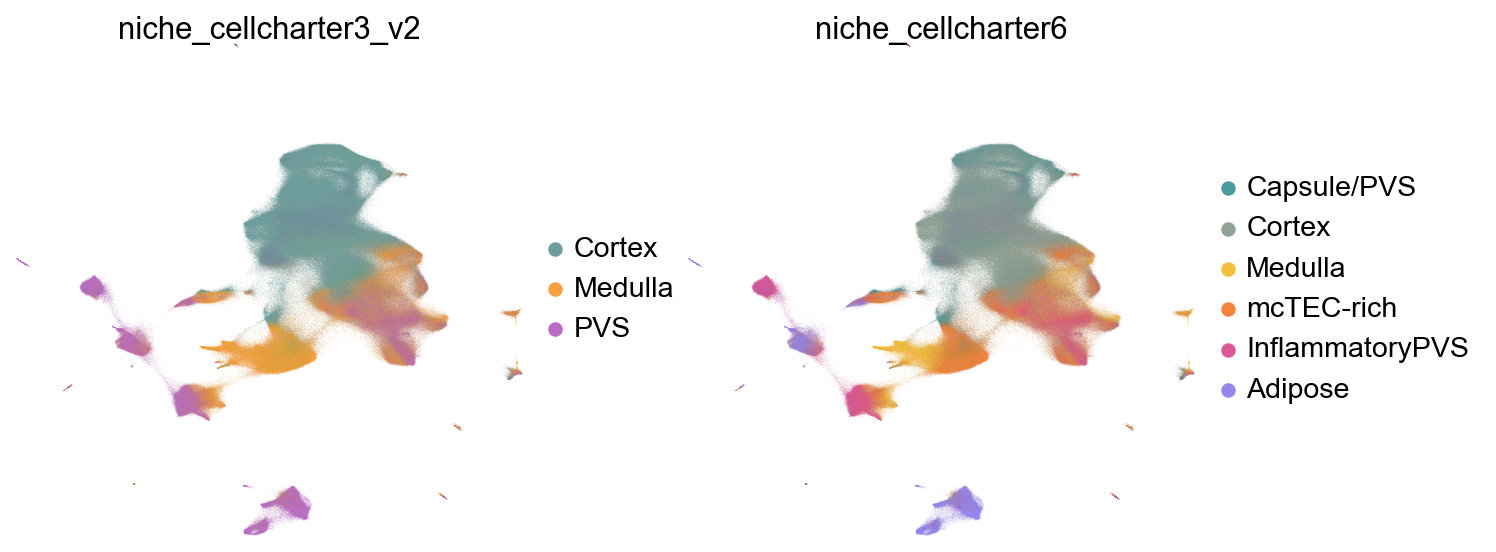

In [47]:
sc.pl.umap(xenium_adata_filt, color = ['niche_cellcharter3_v2', 'niche_cellcharter6'], frameon = False,return_fig = True).savefig(f'{plot_path}/Xenium_UMAP2niche_v2.pdf', dpi = 150)

In [56]:
xenium_adata_filt.obs[['transcript_counts', 'total_counts']]

,transcript_counts,total_counts
Z16_FFPE1_01-aaaaahem-1,426,426
Z16_FFPE1_01-aaaabonk-1,305,305
Z16_FFPE1_01-aaaafhal-1,397,397
Z16_FFPE1_01-aaaaggda-1,515,516
Z16_FFPE1_01-aaaahkcf-1,184,184
...,...,...
A70_FFPE2_01-oikdgnjg-1,134,134
A70_FFPE2_01-oikdmglo-1,136,136
A70_FFPE2_01-oikeoold-1,249,249
A70_FFPE2_01-oikgjlci-1,146,147


## Plot heatmaps with cell type abundance in niches

In [89]:
# Calculate niche compositions for heatmaps
taa_l3_niche_cnts = pd.crosstab(xenium_adata_filt.obs['niche_cellcharter6'], xenium_adata_filt.obs['taa_l3'])
taa_l2_niche_cnts = pd.crosstab(xenium_adata_filt.obs['niche_cellcharter6'], xenium_adata_filt.obs['taa_l2_v2'])
taa_l2_niche_cnts.drop(columns=['TEC-EMT'], inplace = True)
taa_l3_niche_cnts_adult = pd.crosstab(xenium_adata_filt[xenium_adata_filt.obs['Age_group'] == 'adult'].obs['niche_cellcharter6'], xenium_adata_filt[xenium_adata_filt.obs['Age_group'] == 'adult'].obs['taa_l3'])
taa_l2_niche_cnts_adult = pd.crosstab(xenium_adata_filt[xenium_adata_filt.obs['Age_group'] == 'adult'].obs['niche_cellcharter6'], xenium_adata_filt[xenium_adata_filt.obs['Age_group'] == 'adult'].obs['taa_l2_v2'])
taa_l3_niche_cnts_paed = pd.crosstab(xenium_adata_filt[xenium_adata_filt.obs['Age_group'] == 'paed(late)'].obs['niche_cellcharter6'], xenium_adata_filt[xenium_adata_filt.obs['Age_group'] == 'paed(late)'].obs['taa_l3'])
taa_l2_niche_cnts_paed = pd.crosstab(xenium_adata_filt[xenium_adata_filt.obs['Age_group'] == 'paed(late)'].obs['niche_cellcharter6'], xenium_adata_filt[xenium_adata_filt.obs['Age_group'] == 'paed(late)'].obs['taa_l2_v2'])

In [90]:
thyAgeing_colors = pd.read_csv("/nfs/team205/lm25/thymus_projects/thymus_ageing_atlas/General_analysis/scripts/plotting/thyAgeing_colors.csv").set_index('color_name')['hex'].to_dict()
niche_enrich_palette = sns.blend_palette([thyAgeing_colors['blue'], thyAgeing_colors['purple'], thyAgeing_colors['magenta'], thyAgeing_colors['orange'], thyAgeing_colors['yellow']], as_cmap=True,)

In [91]:
dev_cells = ['T_DN(early)',
 'T_DN',
 'T_DP',
 'T_αβT(entry)',
 'T_mature',
 'T_recirc',
 'T_innate',
 'pDC',
 'cTEC',
 'mcTEC',
 'mTEC']
immune_cells = [
 'T_CD4_recirc',
'T_CD8_recirc',
 'T_Treg_recirc',
 'ILC', 
 'B_naive',
 'B_mem',
 'B_GC-like',
 'B_plasma',
 'Neutrophil',
 'Mono',
 'Mac',
 'DC1',
 'DC2',
 'aDC',
 'pDC',
 'Mast', 
 'NK']
tec_cells = ['cTEC',
 'mcTEC',
 'mTECI',
 'mTECII',
 'mTECIII',
 'TEC-mim',
 'TEC-EMT']
recruiter_cells = [ 'Fb-interlo',
 'Fb-perilo',
 'Fb-med',
 'Fb-interm',
 'Fb-adipo',
 'Adipocyte',
 'EC-art',
 'EC-cap',
 'EC-cap_lipid',
 'EC-ven',
 'EC-peri',
 'EC-lymphatic',
 'SMC',
 'Pericyte',]
stromal_cells = [ 'cTEC',
 'mcTEC',
 'mTECI',
 'mTECII',
 'mTECIII',
 'TEC-mim',
 'TEC-EMT',
 'Fb-interlo',
 'Fb-perilo',
 'Fb-med',
 'Fb-interm',
 'Fb-adipo',
 'Adipocyte',
 'EC-art',
 'EC-cap',
 'EC-cap_lipid',
 'EC-ven',
 'EC-peri',
 'EC-lymphatic',
 'SMC',
 'Pericyte']

In [92]:
taa_l2_niche_cnts

taa_l2_v2,T_DN(early),T_DN,T_DP,T_αβT(entry),T_mature,T_recirc,T_innate,NK,cTEC,mcTEC,mTEC,Fb,Adipocyte,EC-blood,EC-lymphatic,SMC,Pericyte,B_cell,B_plasma,Myeloid_dev,Neutrophil,Mono,Mac,DC1,DC2,aDC,pDC,Mast
niche_cellcharter6,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Capsule/PVS,172,7099,96956,16406,17398,20283,6174,57,12578,35600,4175,2674,31,3845,27,480,213,4130,1631,467,12,408,8065,2913,931,188,697,2256
Cortex,153,15487,552360,86331,31197,11474,7394,14,10044,1264,154,8,0,7,0,5,0,661,137,0,0,4,47,11,3,1,29,47
Medulla,5,146,5921,22579,61524,50916,13057,57,573,8734,57337,616,1,381,0,22,14,26568,817,1,1,75,1780,3790,1244,7049,969,131
mcTEC-rich,8,163,2347,8566,12763,15763,3917,9,5481,55534,10206,6503,52,2079,0,281,319,5734,298,258,90,365,10746,390,124,8,24,1536
InflammatoryPVS,5,177,18529,8178,29969,65687,5849,117,0,125,108,6485,39,1292,0,166,216,60671,33675,101,3,185,3631,2442,588,1195,998,2256
Adipose,0,2,227,57,244,1764,65,25,2,121,234,27154,4027,48903,1515,10096,7783,483,1675,34,18,962,4840,66,99,20,2,860


In [93]:
plt.style.use(f'/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/thyAgeing.mplstyle')

In [125]:
def plot_niche_ctype_abundance_heatmap(niche_cnts, celltypes, figsize, title, savepath):
    import seaborn as sns
    import numpy as np
    niche_heatmap = sns.clustermap(niche_cnts[celltypes], standard_scale = 1, col_cluster=False, row_cluster=False,
                                                   cmap = niche_enrich_palette, xticklabels=True, 
                                                   figsize=figsize)
    # Make the heatmap square by setting aspect ratio
    niche_heatmap.ax_heatmap.set_aspect('equal')
    niche_heatmap.ax_heatmap.grid(False)
    niche_heatmap.ax_heatmap.set_title(title)
    # Plot the bar plot
    niche_heatmap.savefig(savepath)

Text(0.5, 1.0, 'Combined lpaed and adult')

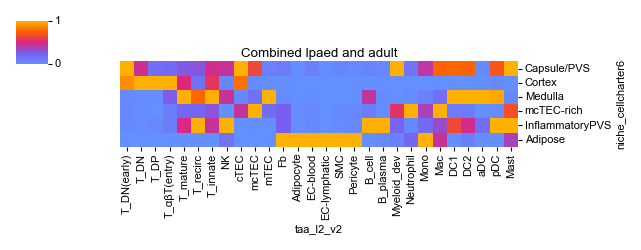

In [ ]:
import seaborn as sns
import numpy as np
#from plotting.utils import calc_figsize
niche_heatmap = sns.clustermap(taa_l2_niche_cnts, standard_scale = 1, col_cluster=False, row_cluster=False,
                                               cmap = niche_enrich_palette, xticklabels=True, yticklabels = True, 
                                               figsize=(4.0,1.5))
# Make the heatmap square by setting aspect ratio
niche_heatmap.ax_heatmap.set_aspect('equal')
niche_heatmap.ax_heatmap.grid(False)
niche_heatmap.ax_heatmap.set_title('Combined lpaed and adult')

# Plot the bar plot
niche_heatmap.savefig(f"{plot_path}/xenium/niche_ctype_abundance/ThyAge_xenium_cellcharter_niche6_ctype_abundance_taa_l2_v2_cmap.pdf")


<Figure size 240x40 with 0 Axes>

Text(0, 0.5, 'Total cells (log scale)')

Text(0.5, 0, 'Cell type')

/tmp/ipykernel_2545651/2887620571.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_col.set_xticklabels(ax_col.get_xticklabels(), rotation=90)


[Text(0, 0, 'T_DN(early)'),
 Text(1, 0, 'T_DN'),
 Text(2, 0, 'T_DP'),
 Text(3, 0, 'T_αβT(entry)'),
 Text(4, 0, 'T_mature'),
 Text(5, 0, 'T_recirc'),
 Text(6, 0, 'T_innate'),
 Text(7, 0, 'NK'),
 Text(8, 0, 'cTEC'),
 Text(9, 0, 'mcTEC'),
 Text(10, 0, 'mTEC'),
 Text(11, 0, 'TEC-EMT'),
 Text(12, 0, 'Fb'),
 Text(13, 0, 'Adipocyte'),
 Text(14, 0, 'EC-blood'),
 Text(15, 0, 'EC-lymphatic'),
 Text(16, 0, 'SMC'),
 Text(17, 0, 'Pericyte'),
 Text(18, 0, 'B_cell'),
 Text(19, 0, 'B_plasma'),
 Text(20, 0, 'Myeloid_dev'),
 Text(21, 0, 'Neutrophil'),
 Text(22, 0, 'Mono'),
 Text(23, 0, 'Mac'),
 Text(24, 0, 'DC1'),
 Text(25, 0, 'DC2'),
 Text(26, 0, 'aDC'),
 Text(27, 0, 'pDC'),
 Text(28, 0, 'Mast')]

/tmp/ipykernel_2545651/2887620571.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


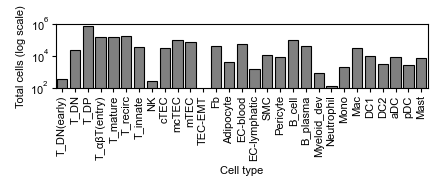

In [111]:
import seaborn as sns
# Plot the bar plot
col_sums = taa_l2_niche_cnts.sum(axis=0)
# Plot barplot of total counts per cell type (log scale, compact, no grid)
import matplotlib.pyplot as plt
plt.figure(figsize=(3.0,0.5))
ax_col = sns.barplot(x=col_sums.index, y=col_sums.values, color='gray')
ax_col.set_yscale('log')
ax_col.set_ylabel('Total cells (log scale)')
ax_col.set_xlabel('Cell type')
ax_col.set_xticklabels(ax_col.get_xticklabels(), rotation=90)
ax_col.grid(False)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Late paediatric')

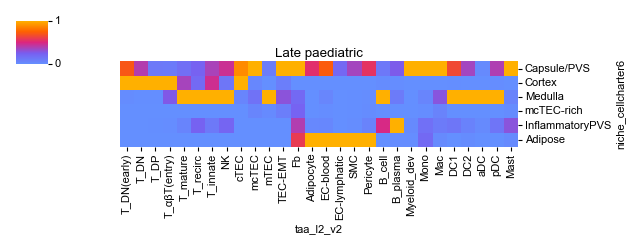

In [104]:
import seaborn as sns
import numpy as np
#from plotting.utils import calc_figsize
niche_heatmap = sns.clustermap(taa_l2_niche_cnts_paed, standard_scale = 1, col_cluster=False, row_cluster=False,
                                               cmap = niche_enrich_palette, xticklabels=True, yticklabels = True, 
                                               figsize=(4,1.5))
# Make the heatmap square by setting aspect ratio
niche_heatmap.ax_heatmap.set_aspect('equal')
niche_heatmap.ax_heatmap.grid(False)
niche_heatmap.ax_heatmap.set_title('Late paediatric')
# Add a bar plot on top showing the total counts per column (cell type)

# Plot the bar plot
niche_heatmap.savefig(f"{plot_path}/xenium/niche_ctype_abundance/ThyAge_xenium_cellcharter_niche6_ctype_abundance_paed_taa_l2_v2_cmap.pdf")


Text(0.5, 1.0, 'Adult')

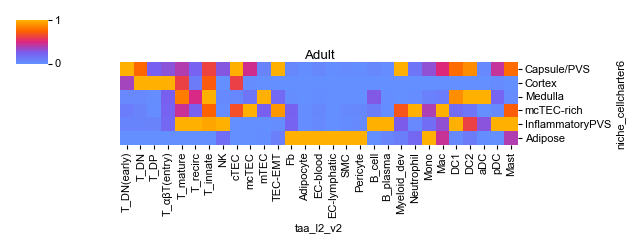

In [ ]:
import seaborn as sns
import numpy as np
#from plotting.utils import calc_figsize
niche_heatmap = sns.clustermap(taa_l2_niche_cnts_adult, standard_scale = 1, col_cluster=False, row_cluster=False,
                                               cmap = niche_enrich_palette, xticklabels=True, yticklabels = True, 
                                               figsize=(4,1.5))
# Make the heatmap square by setting aspect ratio
niche_heatmap.ax_heatmap.set_aspect('equal')
niche_heatmap.ax_heatmap.grid(False)
niche_heatmap.ax_heatmap.set_title('Adult')
# Plot the bar plot
niche_heatmap.savefig(f"{plot_path}/xenium/niche_ctype_abundance/ThyAge_xenium_cellcharter_niche6_ctype_abundance_adult_taa_l2_v2_cmap.pdf")


## TEC cells plotting

Text(0.5, 1.0, 'Combined lpaed and adult')

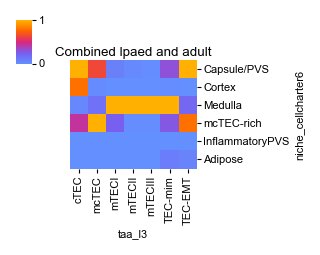

In [122]:
import seaborn as sns
import numpy as np
niche_heatmap = sns.clustermap(taa_l3_niche_cnts[tec_cells], standard_scale = 1, col_cluster=False, row_cluster=False,
                                               cmap = niche_enrich_palette, xticklabels=True, 
                                               figsize=(2, 1.5))
# Make the heatmap square by setting aspect ratio
niche_heatmap.ax_heatmap.set_aspect('equal')
niche_heatmap.ax_heatmap.grid(False)
niche_heatmap.ax_heatmap.set_title('Combined lpaed and adult')

# Plot the bar plot
niche_heatmap.savefig(f"{plot_path}/xenium/niche_ctype_abundance/ThyAge_xenium_cellcharter_niche6_ctype_abundance_taa_l3_TEC_cmap.pdf")


Text(0.5, 1.0, 'Adult')

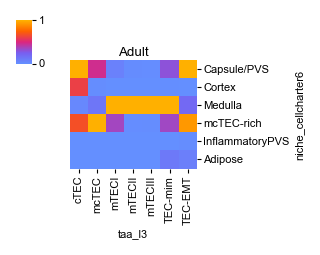

In [124]:
import seaborn as sns
import numpy as np
niche_heatmap = sns.clustermap(taa_l3_niche_cnts_adult[tec_cells], standard_scale = 1, col_cluster=False, row_cluster=False,
                                               cmap = niche_enrich_palette, xticklabels=True, 
                                               figsize=(2, 1.5))
# Make the heatmap square by setting aspect ratio
niche_heatmap.ax_heatmap.set_aspect('equal')
niche_heatmap.ax_heatmap.grid(False)
niche_heatmap.ax_heatmap.set_title('Adult')

# Plot the bar plot
niche_heatmap.savefig(f"{plot_path}/xenium/niche_ctype_abundance/ThyAge_xenium_cellcharter_niche6_ctype_abundance_taa_l3_adult_TEC_cmap.pdf")


## Stromal recruiter cells plotting

Text(0.5, 1.0, 'Combined lpaed and adult')

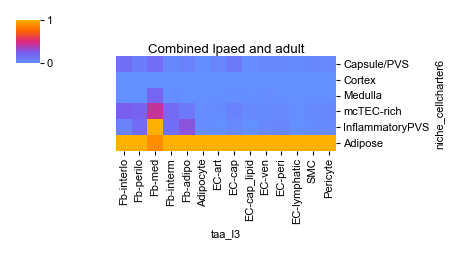

In [118]:
import seaborn as sns
import numpy as np
niche_heatmap = sns.clustermap(taa_l3_niche_cnts[recruiter_cells], standard_scale = 1, col_cluster=False, row_cluster=False,
                                               cmap = niche_enrich_palette, xticklabels=True, yticklabels = True, 
                                               figsize=(3, 1.5))
# Make the heatmap square by setting aspect ratio
niche_heatmap.ax_heatmap.set_aspect('equal')
niche_heatmap.ax_heatmap.grid(False)
niche_heatmap.ax_heatmap.set_title('Combined lpaed and adult')
# Plot the bar plot
niche_heatmap.savefig(f"{plot_path}/xenium/niche_ctype_abundance/ThyAge_xenium_cellcharter_niche6_ctype_abundance_stroma_taa_l3_cmap.pdf")


Text(0.5, 1.0, 'Late paediatric')

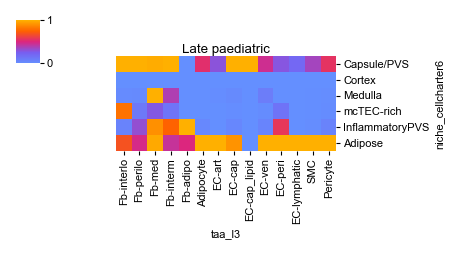

In [119]:
import seaborn as sns
import numpy as np
niche_heatmap = sns.clustermap(taa_l3_niche_cnts_paed[recruiter_cells], standard_scale = 1, col_cluster=False, row_cluster=False,
                                               cmap = niche_enrich_palette, xticklabels=True, yticklabels = True, 
                                               figsize=(3, 1.5))
# Make the heatmap square by setting aspect ratio
niche_heatmap.ax_heatmap.set_aspect('equal')
niche_heatmap.ax_heatmap.grid(False)
niche_heatmap.ax_heatmap.set_title('Late paediatric')
# Plot the bar plot
niche_heatmap.savefig(f"{plot_path}/xenium/niche_ctype_abundance/ThyAge_xenium_cellcharter_niche6_ctype_abundance_stroma_paed_taa_l3_cmap.pdf")


Text(0.5, 1.0, 'Adult')

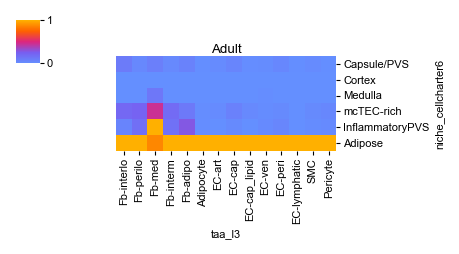

In [120]:
import seaborn as sns
import numpy as np
niche_heatmap = sns.clustermap(taa_l3_niche_cnts_adult[recruiter_cells], standard_scale = 1, col_cluster=False, row_cluster=False,
                                               cmap = niche_enrich_palette, xticklabels=True, yticklabels = True, 
                                               figsize=(3, 1.5))
# Make the heatmap square by setting aspect ratio
niche_heatmap.ax_heatmap.set_aspect('equal')
niche_heatmap.ax_heatmap.grid(False)
niche_heatmap.ax_heatmap.set_title('Adult')
# Plot the bar plot
niche_heatmap.savefig(f"{plot_path}/xenium/niche_ctype_abundance/ThyAge_xenium_cellcharter_niche6_ctype_abundance_stroma_adult_taa_l3_cmap.pdf")


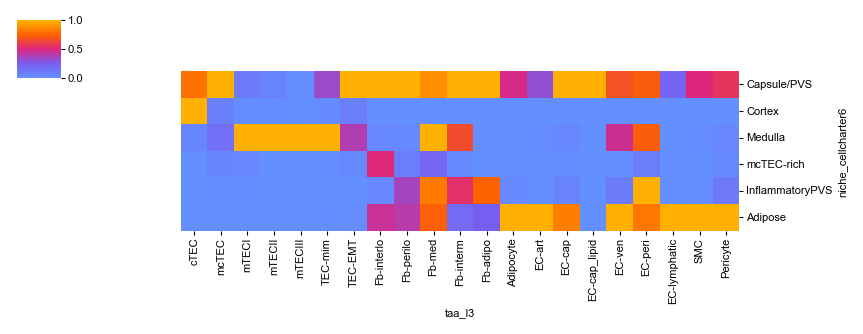

In [53]:
import seaborn as sns
import numpy as np
niche_heatmap = sns.clustermap(taa_l3_niche_cnts_paed[stromal_cells], standard_scale = 1, col_cluster=False, row_cluster=False,
                                               cmap = niche_enrich_palette, xticklabels=True, yticklabels = True, 
                                               figsize=(5.5, 2))
# Make the heatmap square by setting aspect ratio
niche_heatmap.ax_heatmap.set_aspect('equal')
niche_heatmap.ax_heatmap.grid(False)

# Add a bar plot on top showing the total counts per column (cell type)

# Plot the bar plot
niche_heatmap.savefig(f"{plot_path}/xenium/ThyAge_xenium_cellcharter_niche6_ctype_abundance_stroma_paed_taa_l3_upd_cmap.pdf")


### Immune cell plotting 

In [ ]:
def plot_niche_ctype_abundance_heatmap(niche_cnts, celltypes, figsize, title, savepath):
    import seaborn as sns
    import numpy as np
    niche_heatmap = sns.clustermap(niche_cnts[celltypes], standard_scale = 1, col_cluster=False, row_cluster=False,
                                                   cmap = niche_enrich_palette, xticklabels=True, 
                                                   figsize=figsize)
    # Make the heatmap square by setting aspect ratio
    niche_heatmap.ax_heatmap.set_aspect('equal')
    niche_heatmap.ax_heatmap.grid(False)
    niche_heatmap.ax_heatmap.set_title(title)
    # Plot the bar plot
    niche_heatmap.savefig(savepath)

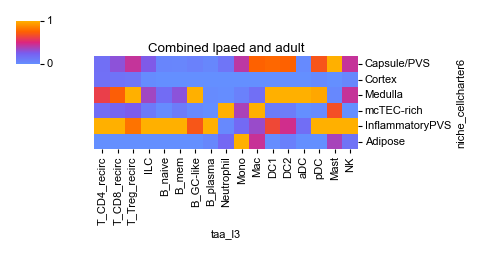

In [127]:
plot_niche_ctype_abundance_heatmap(taa_l3_niche_cnts, celltypes=immune_cells, figsize=(3.0,1.5), title='Combined lpaed and adult',
                                 savepath=f"{plot_path}/xenium/niche_ctype_abundance/ThyAge_xenium_cellcharter_niche6_ctype_abundance_immune_taa_l3_cmap.pdf")

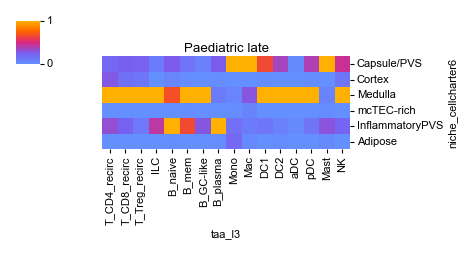

In [130]:
plot_niche_ctype_abundance_heatmap(taa_l3_niche_cnts_paed, celltypes=[i for i in immune_cells if i in taa_l3_niche_cnts_paed.columns], figsize=(3.0,1.5), title='Paediatric late',
                                 savepath=f"{plot_path}/xenium/niche_ctype_abundance/ThyAge_xenium_cellcharter_niche6_ctype_abundance_immune_lpaed_taa_l3_cmap.pdf")

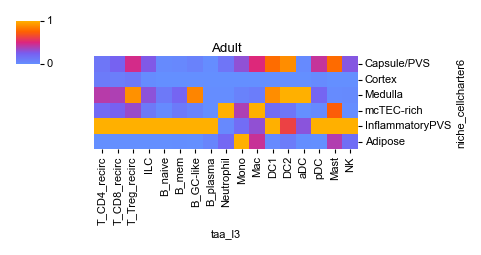

In [131]:
plot_niche_ctype_abundance_heatmap(taa_l3_niche_cnts_adult, celltypes=[i for i in immune_cells if i in taa_l3_niche_cnts_adult.columns], figsize=(3.0,1.5), title='Adult',
                                 savepath=f"{plot_path}/xenium/niche_ctype_abundance/ThyAge_xenium_cellcharter_niche6_ctype_abundance_immune_adult_taa_l3_cmap.pdf")

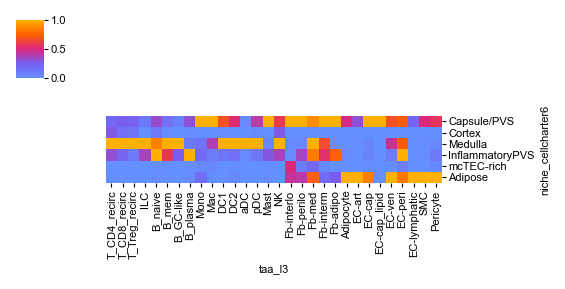

In [115]:
import seaborn as sns
import numpy as np
niche_heatmap = sns.clustermap(taa_l3_niche_cnts_paed[[i for i in immune_cells+recruiter_cells if i in taa_l3_niche_cnts_paed.columns]], standard_scale = 1, col_cluster=False, row_cluster=False,
                                               cmap = niche_enrich_palette, xticklabels=True, yticklabels = True, 
                                               figsize=(3.5, 2))
# Make the heatmap square by setting aspect ratio
niche_heatmap.ax_heatmap.set_aspect('equal')
niche_heatmap.ax_heatmap.grid(False)

# Add a bar plot on top showing the total counts per column (cell type)

# Plot the bar plot
niche_heatmap.savefig(f"{plot_path}/xenium/ThyAge_xenium_cellcharter_niche6_ctype_abundance_immune_recruiter_taa_l3_paed_upd_cmap.pdf")


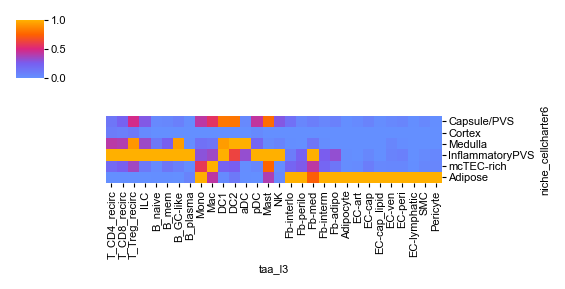

In [114]:
import seaborn as sns
import numpy as np
niche_heatmap = sns.clustermap(taa_l3_niche_cnts_adult[[i for i in immune_cells+recruiter_cells if i in taa_l3_niche_cnts_paed.columns]], standard_scale = 1, col_cluster=False, row_cluster=False,
                                               cmap = niche_enrich_palette, xticklabels=True, yticklabels = True, 
                                               figsize=(3.5, 2))
# Make the heatmap square by setting aspect ratio
niche_heatmap.ax_heatmap.set_aspect('equal')
niche_heatmap.ax_heatmap.grid(False)

# Add a bar plot on top showing the total counts per column (cell type)

# Plot the bar plot
niche_heatmap.savefig(f"{plot_path}/xenium/ThyAge_xenium_cellcharter_niche6_ctype_abundance_immune_recruiter_taa_l3_adult_upd_cmap.pdf")


## Save annotations for each sample

In [ ]:
def save_anno_lev(adata, anno, today):
    anno_levels = get_ct_levels(level = anno)
    anno_palette = get_ct_palette(level = anno)
    adata.obs[anno] = adata.obs[anno].astype('category')
    adata.obs[anno] = adata.obs[anno].cat.reorder_categories(anno_levels).copy()
    # Save the palette
    adata.uns[f'{anno}_colors'] = anno_palette.copy()
    # Save the annotations
    adata.obs[[anno]].to_csv(f'{data_path}/xenium/annos_v3/ThyAge_xenium_adata_paed+adult_{anno}_annos_filt_{today}.csv', index = True)

In [136]:
xenium_adata_filt.obs.columns

Index(['cell_id', 'transcript_counts', 'control_probe_counts',
       'genomic_control_counts', 'control_codeword_counts',
       'unassigned_codeword_counts', 'deprecated_codeword_counts',
       'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count',
       'segmentation_method', 'region', 'z_level', 'cell_labels', 'SampleID',
       'Sample', 'Sample_hr', 'Sequencer', 'SlideID', 'Position', 'Image_name',
       'Image_jpg', 'section_thickness (um)', 'permebialisation(min)',
       'RIN/DV200', 'Spatial_type', 'Chemistry_detail', 'Probeset',
       'Number of genes', 'DonorID', 'Donor_type', 'Age_group', 'Age(misc)',
       'Age(numeric)', 'age_months', 'Source', 'Study', 'Study name ',
       'Study ID', 'published', 'Sex', 'QC', 'Batch', 'Spaceranger',
       'old_sample_name', 'annotation version', 'updated pipeline', 'L1_knn1',
       'L0_KNN10', 'for mapping', 'n_counts', 'knn_pred-taa_l5',
       'knn_pred-taa_l4', 'knn_pred-taa_l3', 'knn_pred-taa_l2',
       'knn_pred-ta

In [141]:
xenium_adata_filt.obs[['SampleID', 'Sample_hr']]

,SampleID,Sample_hr
Z16_FFPE1_01-aaaaahem-1,Z16-THY-0-FF-1,Z16_FFPE1_01
Z16_FFPE1_01-aaaabonk-1,Z16-THY-0-FF-1,Z16_FFPE1_01
Z16_FFPE1_01-aaaafhal-1,Z16-THY-0-FF-1,Z16_FFPE1_01
Z16_FFPE1_01-aaaaggda-1,Z16-THY-0-FF-1,Z16_FFPE1_01
Z16_FFPE1_01-aaaahkcf-1,Z16-THY-0-FF-1,Z16_FFPE1_01
...,...,...
A70_FFPE2_01-oikdgnjg-1,A70-THY-0-FFPE-2,A70_FFPE2_01
A70_FFPE2_01-oikdmglo-1,A70-THY-0-FFPE-2,A70_FFPE2_01
A70_FFPE2_01-oikeoold-1,A70-THY-0-FFPE-2,A70_FFPE2_01
A70_FFPE2_01-oikgjlci-1,A70-THY-0-FFPE-2,A70_FFPE2_01


In [137]:
for sample in xenium_adata_filt.obs['SampleID'].unique().tolist():
    obs = xenium_adata_filt.obs[xenium_adata_filt.obs['SampleID'] == sample]
    obs.set_index('cell_id', inplace = True)
    obs[['taa_l3']].rename(columns = {'taa_l3':'group'}).to_csv(f'{data_path}/xenium/annos_v3/{sample}-taa_l3.csv', index = True)
    obs[['taa_l2_v2']].rename(columns = {'taa_l2_v2':'group'}).to_csv(f'{data_path}/xenium/annos_v3/{sample}-taa_l2.csv', index = True)
    obs[['niche_cellcharter6']].rename(columns = {'niche_cellcharter6':'group'}).to_csv(f'{data_path}/xenium/annos_v3/{sample}-niches.csv', index = True)
    obs[['niche_cellcharter3_v2']].rename(columns = {'niche_cellcharter3_v2':'group'}).to_csv(f'{data_path}/xenium/annos_v3/{sample}-compartments.csv', index = True)


